In [44]:
from IPython.display import Image

import pandas as pd
import numpy as np
from pprint import pprint

from collections import Counter

import os, sys
file_dir = '/Users/imsoyoung/Soyoung/Ajou/Project/DigitalPhenotype/DigitalPhenotype_overall/Code/Util'
sys.path.append(os.path.dirname(os.path.abspath
                                (os.path.abspath(file_dir))))

import Util.Utility as util
import json


# 💡 LDA 를 스마트폰 로그 데이터에 적용하기 💡
1. 유저의 앱 사용 기록을 카테고리화 (google-play store) 한 데이터 사용!
2. 유저의 일별 모든 앱 사용의 카테고리를 하나의 문서로 취급
3. 일별 카테고리 이용 문서를 LDA 
    - LDA 기초 공부
    - Category 데이터 텍스트화
    - LDA 적용
    - ISSUE :  Communication 카테고리의 사용 count 가 너무 많음
    - ISSUE 해결 시도 : 각 카테고리별 사용 duration 고려 --> threshold 지정(N seconds 이상 사용한 것만 고려)







# LDA 기초

말뭉치로부터 토픽을 추출하는 Topic Modeling 기법 가운데 하나인 LDA (Latent Dirichlet Allocation)


참고

https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/06/01/LDA/
https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/07/09/lda/

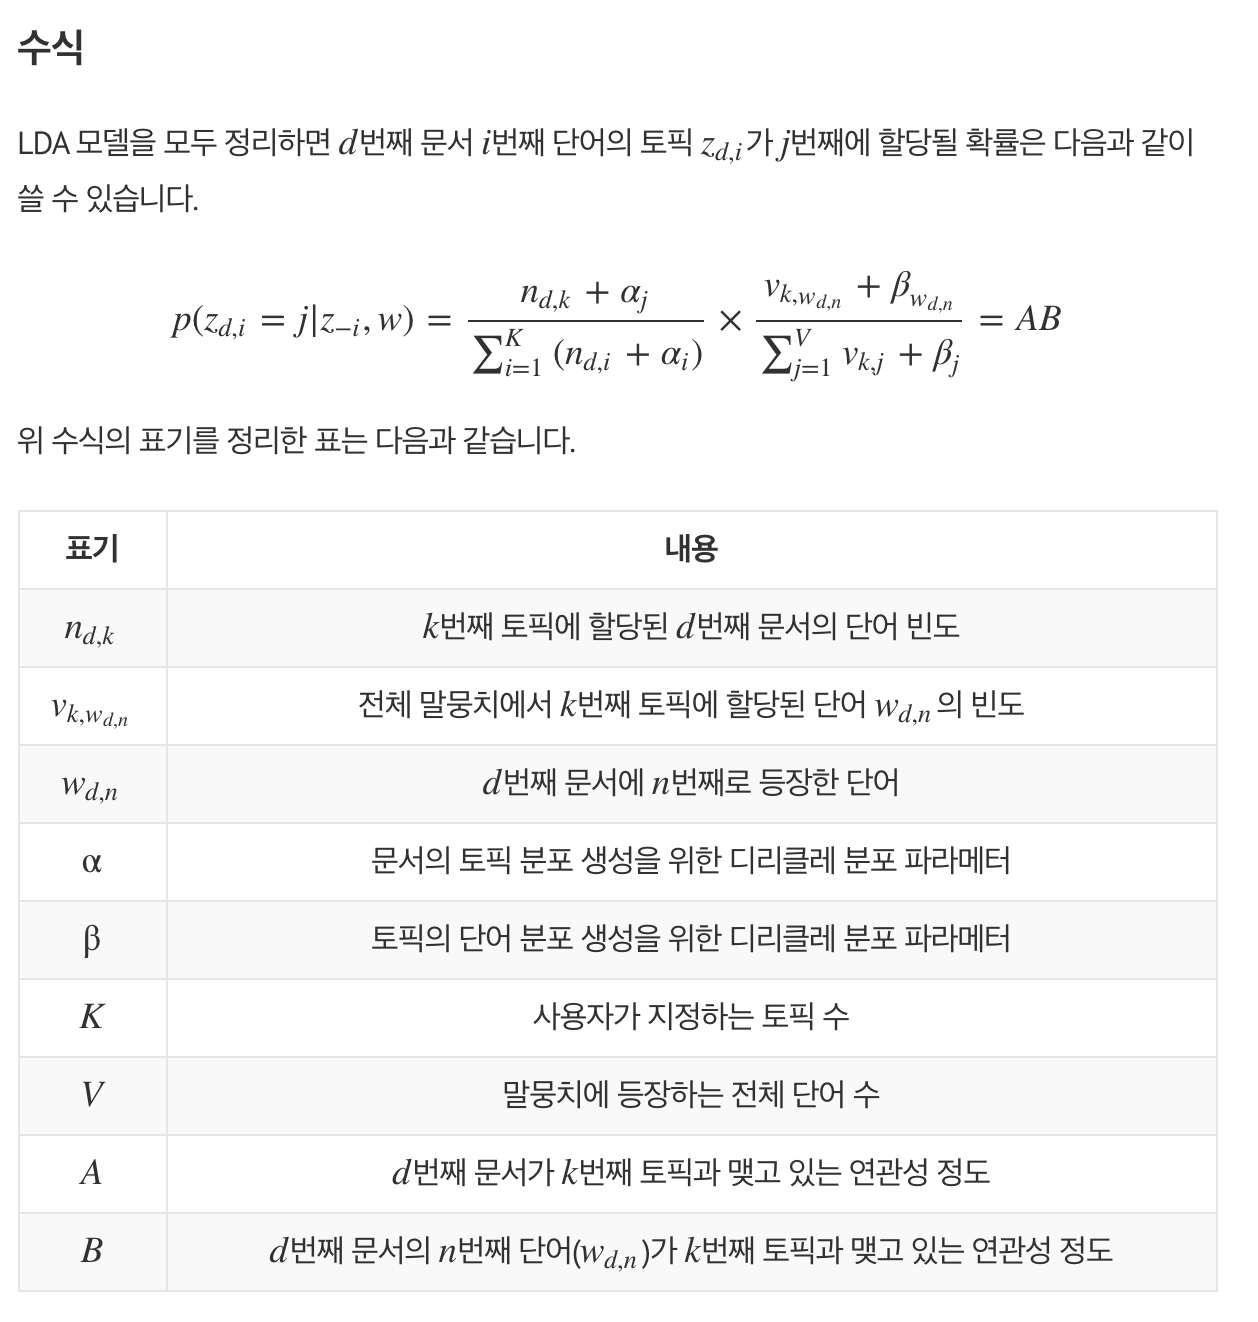

In [2]:
Image("../../img/DP_LDA.png") 

## 변수 선언

- 각 토픽이 각 문서에 할당되는 횟수
- 각 토픽에 할당되는 총 단어수
- 각 단어가 각 토픽에 할당되는 횟수
- 각 문서에 포함되는 총 단어수
- 단어 종류의 수
- 총 문서의 수

ex. document_topic_counts[3][1] : 세번째 문서 중 토픽 1과 관련있는 단어 수

ex. topic_word_counts[2]['nlp'] : nlp 라는 단어가 토픽2와 연관지어 등장한 횟수

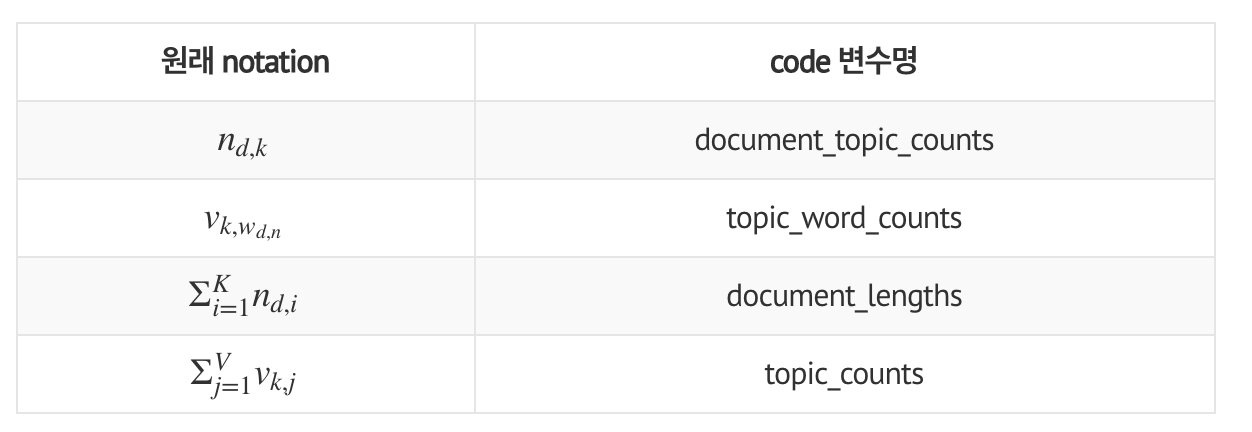

In [3]:
Image("../../img/DP_LDA_variable.png") 

## 새로운 Topic 계산

- A : d번째 문서가 k번째 토픽과 맺고 있는 연관성 정도
- B : d번째 문서의 n번째 등장한 단어가 k 번째 토픽과 맺고 있는 연관성 정도


d번째 문서 i번째 단어의 토픽 z(d,i)가 j번째에 할당될 확률은 A와 B를 곱해 구한다
- A = p_topic_given_document
- B = p_word_given_topic
- topic_weight  = A*B

In [4]:
def p_topic_given_document(topic, d, alpha=0.1):
    # 문서 d의 모든 단어 가운데 topic에 속하는
    # 단어의 비율 (alpha를 더해 smoothing)
    return ((document_topic_counts[d][topic] + alpha) /
            (document_lengths[d] + K * alpha))

def p_word_given_topic(word, topic, beta=0.1):
    # topic에 속한 단어 가운데 word의 비율
    # (beta를 더해 smoothing)
    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + V * beta))

def topic_weight(d, word, k):
    # 문서와 문서의 단어가 주어지면
    # k번째 토픽의 weight를 반환
    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

A*B 값을 바탕으로 샘플링하여 d번째 문서의 i번째 단어의 토픽 z(d,i) 에 새로운 토픽 할당

In [5]:
def choose_new_topic(d, word):
    return sample_from([topic_weight(d, word, k) for k in range(K)])

import random
def sample_from(weights):
    # i를 weights[i] / sum(weights)
    # 확률로 반환
    total = sum(weights)
    # 0과 total 사이를 균일하게 선택
    rnd = total * random.random()
    # 아래 식을 만족하는 가장 작은 i를 반환
    # weights[0] + ... + weights[i] >= rnd
    for i, w in enumerate(weights):
        rnd -= w
        if rnd <= 0:
            return i

# Category 앱 사용 데이터 Text 화

## Make Documents

In [7]:
app = pd.read_csv('../01.Preprocess/result/A_categorized.csv')
util.toDatetime(app, ['date'], '%Y%m%d')
app.head(3)

,Unnamed: 0,_id,uid,date,stime,etime,packageName,total,isInUsable,packageFullName,category
0,2,3,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:11:59,2018-12-03 00:12:10,캐시워크,11,True,com.cashwalk.cashwalk,Health & Fitness
1,17,20,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:13:21,2018-12-03 00:13:24,카카오톡,3,True,com.kakao.talk,Communication
2,19,22,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:13:32,2018-12-03 00:13:33,카카오톡,1,True,com.kakao.talk,Communication


In [8]:
date_unique = list(set(app['date']))

docs = {}
for date in date_unique:
    docs[date] = ""
    docs[date] += (app[app['date']==date]['category'].values)

np.save('result/category_docs.npy', docs)


In [9]:
doc_df = pd.DataFrame(list(docs.items()),columns = ['date','category_docs']) 

doc_df.head()
##이미 tokenize 형태로 되어 있음!


,date,category_docs
0,2018-12-19,"[Music, Music, Music, Music, Communication, Mu..."
1,2018-12-10,"[Communication, Communication, Communication, ..."
2,2018-12-24,"[Health & Fitness, Health & Fitness, Health & ..."
3,2018-12-23,"[Communication, Comics, Communication, Health ..."
4,2018-12-22,"[Health & Fitness, Health & Fitness, Communica..."


# LDA 적용

## Solution1

In [15]:
def LDA_ratsgo(documsnts, K):
    # 각 토픽이 각 문서에 할당되는 횟수
    # Counter로 구성된 리스트
    # 각 Counter는 각 문서를 의미
    document_topic_counts = [Counter() for _ in documents]

    # 각 단어가 각 토픽에 할당되는 횟수
    # Counter로 구성된 리스트
    # 각 Counter는 각 토픽을 의미
    topic_word_counts = [Counter() for _ in range(K)]

    # 각 토픽에 할당되는 총 단어수
    # 숫자로 구성된 리스트
    # 각각의 숫자는 각 토픽을 의미함
    topic_counts = [0 for _ in range(K)]

    # 각 문서에 포함되는 총 단어수
    # 숫자로 구성된 리스트
    # 각각의 숫자는 각 문서를 의미함
    document_lengths = map(len, documents)

    # 단어 종류의 수
    distinct_words = set(word for document in documents for word in document)
    V = len(distinct_words)

    # 총 문서의 수
    D = len(documents)


    # 각 단어를 임의의 토픽에 랜덤 배정
    document_topics = [[random.randrange(K) for word in document]
                        for document in documents]

    # 위와 같이 랜덤 초기화한 상태에서 
    # AB를 구하는 데 필요한 숫자를 세어봄
    for d in range(D):
        for word, topic in zip(documents[d], document_topics[d]):
            document_topic_counts[d][topic] += 1
            topic_word_counts[topic][word] += 1
            topic_counts[topic] += 1
    return [document_topic_counts, topic_word_counts, topic_counts, document_lengths,distinct_words, V, D ]

In [17]:
random.seed(0)

# topic 수 지정
K=4
documents = doc_df['category_docs'].values
result = LDA_ratsgo(documents, K)

print("첫번째 문서의 토픽 비중 : ", result[0][0])
print("첫번째 토픽의 단어 비중 : " , result[1][0])

첫번째 문서의 토픽 비중 :  Counter({0: 52, 2: 46, 1: 42, 3: 37})
첫번째 토픽의 단어 비중 :  Counter({'Communication': 629, 'Health & Fitness': 414, 'Background': 110, 'Comics': 38, 'Food & Drink': 37, 'Music': 31, 'Education': 28, 'Photography': 27, 'Finance': 19, 'Shopping': 16, 'Productivity': 15, 'Entertainment': 12, 'Travel & Local': 7, 'Books & Reference': 4, 'Lifestyle': 1, 'Business': 1})


<div class="mark">
** 문제점 **
- Communication 의 영향력이 너무 큼
- 카테고리별 사용시간의 threshold 구하기!</div><i class="fa fa-lightbulb-o "></i>

## Category threshold!

In [22]:
app.head(3)

,Unnamed: 0,_id,uid,date,stime,etime,packageName,total,isInUsable,packageFullName,category
0,2,3,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:11:59,2018-12-03 00:12:10,캐시워크,11,True,com.cashwalk.cashwalk,Health & Fitness
1,17,20,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:13:21,2018-12-03 00:13:24,카카오톡,3,True,com.kakao.talk,Communication
2,19,22,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:13:32,2018-12-03 00:13:33,카카오톡,1,True,com.kakao.talk,Communication


### 앱 사용시간 기준

9.0


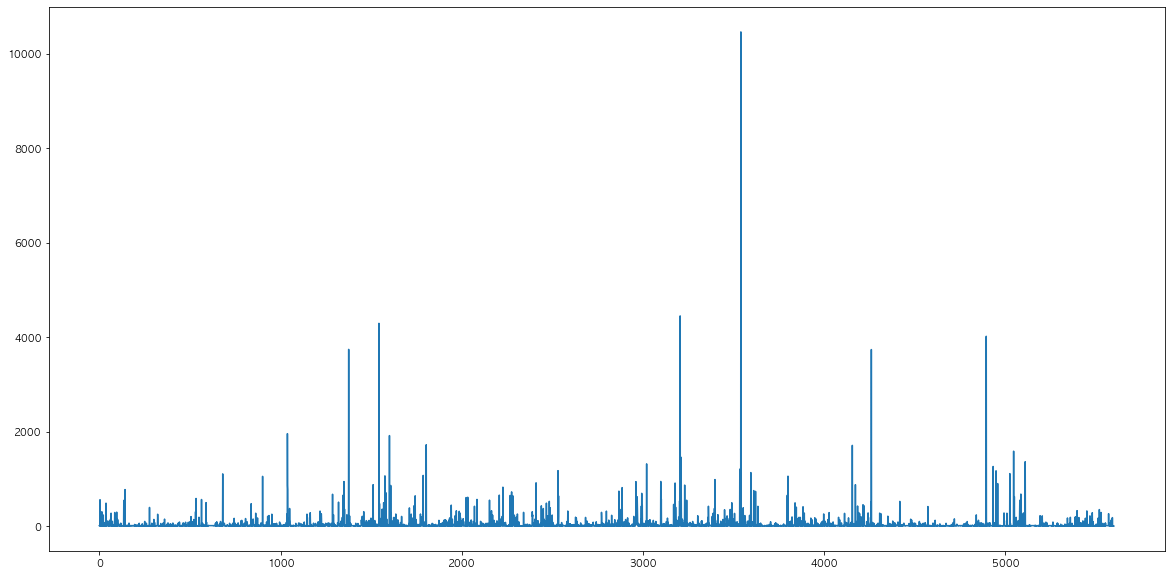

In [23]:
app.head()
print(app['total'].median())
app['total'].plot()

### 카테고리별 앱 사용시간 기준

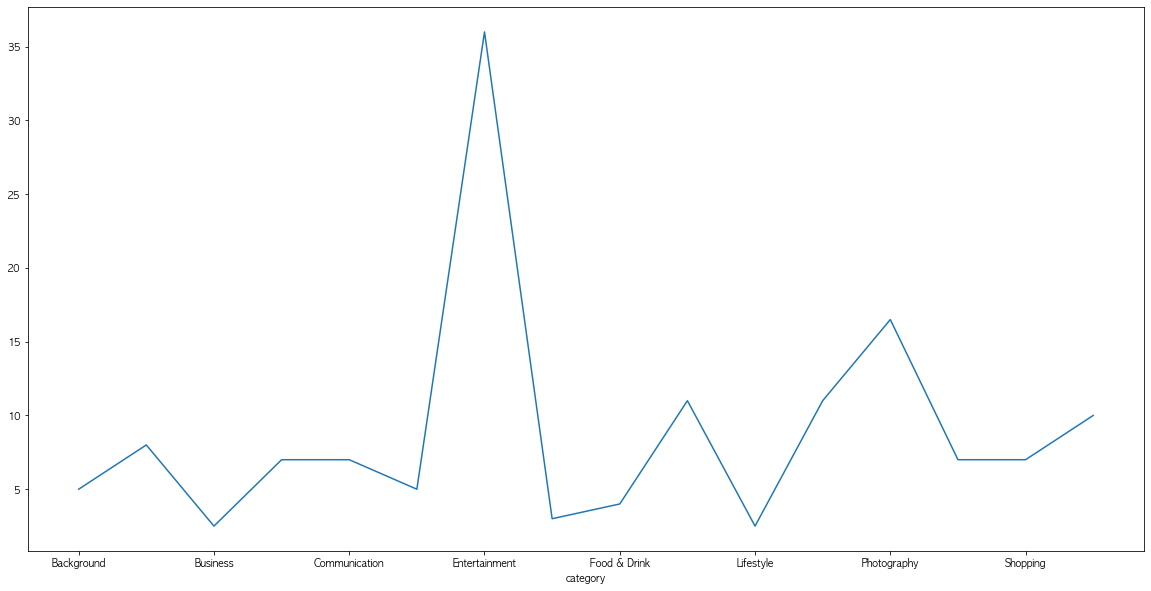

In [24]:
app.groupby(['category'])['total'].median().plot()

In [29]:
app.groupby(['category'])['total'].median()

category
Background            5.0
Books & Reference     8.0
Business              2.5
Comics                7.0
Communication         7.0
Education             5.0
Entertainment        36.0
Finance               3.0
Food & Drink          4.0
Health & Fitness     11.0
Lifestyle             2.5
Music                11.0
Photography          16.5
Productivity          7.0
Shopping              7.0
Travel & Local       10.0
Name: total, dtype: float64

## Solution2
- 9초, 15초 이상 사용한 것만 사용

https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [30]:
app_threshold = app[app['total']>15]
docs_threshold = {}

for date in date_unique:
    docs_threshold[date] = ""
    docs_threshold[date] += (app_threshold[app_threshold['date']==date]['category'].values)

doc_df_threshold = pd.DataFrame(list(docs_threshold.items()),columns = ['date','category_docs']) 


In [31]:
doc_df_threshold.head()

,date,category_docs
0,2018-12-19,"[Communication, Music, Background, Communicati..."
1,2018-12-10,"[Communication, Communication, Communication, ..."
2,2018-12-24,"[Education, Education, Education, Education, C..."
3,2018-12-23,"[Entertainment, Entertainment, Communication, ..."
4,2018-12-22,"[Health & Fitness, Health & Fitness, Communica..."


In [32]:
documents_threshold = doc_df_threshold['category_docs'].values

In [33]:
random.seed(0)

# topic 수 지정
K=4
result = LDA_ratsgo(documents_threshold, K)

print("첫번째 문서의 토픽 비중 : ", result[0][0])
print("첫번째 토픽의 단어 비중 : " , result[1][0])

첫번째 문서의 토픽 비중 :  Counter({0: 52, 2: 46, 1: 42, 3: 37})
첫번째 토픽의 단어 비중 :  Counter({'Communication': 629, 'Health & Fitness': 414, 'Background': 110, 'Comics': 38, 'Food & Drink': 37, 'Music': 31, 'Education': 28, 'Photography': 27, 'Finance': 19, 'Shopping': 16, 'Productivity': 15, 'Entertainment': 12, 'Travel & Local': 7, 'Books & Reference': 4, 'Lifestyle': 1, 'Business': 1})


# Gensim 활용
http://www.engear.net/wp/topic-modeling-gensimpython/

In [34]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
 
# spacy for lemmatization
import spacy
 
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
 

## 단어 토큰화

(현재 데이터에선 bigranm, trigram, stopwords 제거 불필요)

In [37]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

data_sample = doc_df['category_docs'].values       
data_words = list(sent_to_words(data_sample))
 
print(data_words)

[['music', 'music', 'music', 'music', 'communication', 'music', 'background', 'communication', 'communication', 'background', 'background', 'communication', 'music', 'music', 'music', 'communication', 'communication', 'communication', 'communication', 'health', 'fitness', 'comics', 'communication', 'comics', 'communication', 'communication', 'health', 'fitness', 'health', 'fitness', 'health', 'fitness', 'health', 'fitness', 'health', 'fitness', 'communication', 'background', 'communication', 'health', 'fitness', 'communication', 'communication', 'health', 'fitness', 'communication', 'communication', 'health', 'fitness', 'health', 'fitness', 'health', 'fitness', 'health', 'fitness', 'health', 'fitness', 'health', 'fitness', 'health', 'fitness', 'health', 'fitness', 'background', 'health', 'fitness', 'health', 'fitness', 'communication', 'background', 'health', 'fitness', 'communication', 'health', 'fitness', 'communication', 'health', 'fitness', 'health', 'fitness', 'background', 'healt

## Topic 모델에 필요한 사전, 코퍼스 생성

- 문서 안의 각 단어에 대해 유니크한 ID 생성
- output : (word_id, word_freqeuncy)

In [41]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
 
# Create Corpus
texts = data_words
 
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
 
# View
print(corpus[:1])
print(id2word[0])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 22), (1, 2), (2, 7), (3, 68), (4, 3), (5, 6), (6, 57), (7, 57), (8, 10), (9, 1), (10, 1), (11, 2)]]
background


[[('background', 22),
  ('books', 2),
  ('comics', 7),
  ('communication', 68),
  ('education', 3),
  ('entertainment', 6),
  ('fitness', 57),
  ('health', 57),
  ('music', 10),
  ('photography', 1),
  ('productivity', 1),
  ('reference', 2)]]

## Topic model

In [49]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
id2word=id2word,
num_topics=10,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto',
per_word_topics=True)

In [50]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.259*"communication" + 0.158*"health" + 0.158*"fitness" + 0.151*"drink" + '
  '0.151*"food" + 0.038*"background" + 0.032*"comics" + 0.021*"music" + '
  '0.011*"entertainment" + 0.011*"finance"'),
 (1,
  '0.285*"communication" + 0.283*"health" + 0.252*"fitness" + '
  '0.067*"background" + 0.050*"photography" + 0.024*"education" + '
  '0.010*"music" + 0.007*"productivity" + 0.007*"travel" + 0.006*"local"'),
 (2,
  '0.272*"fitness" + 0.256*"health" + 0.242*"communication" + '
  '0.098*"background" + 0.048*"music" + 0.016*"productivity" + '
  '0.016*"entertainment" + 0.012*"comics" + 0.008*"local" + 0.008*"travel"'),
 (3,
  '0.333*"fitness" + 0.331*"health" + 0.249*"communication" + '
  '0.039*"education" + 0.014*"background" + 0.012*"finance" + '
  '0.010*"entertainment" + 0.006*"comics" + 0.002*"productivity" + '
  '0.001*"shopping"'),
 (4,
  '0.559*"communication" + 0.142*"fitness" + 0.136*"health" + '
  '0.048*"background" + 0.036*"comics" + 0.017*"productivity" + '
  '0.014*"

## Model 난이도, 일관성 점수

In [51]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.
 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -1.7877513700303374

Coherence Score:  0.2775259019923281


In [52]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.114521  0.020044       1        1  28.539988
2      0.089110 -0.010755       2        1  23.606657
1      0.118070 -0.000918       3        1  17.328674
3      0.170203 -0.019494       4        1  13.620297
0      0.037137 -0.101357       5        1  12.585105
6      0.084459  0.093821       6        1   4.288321
7     -0.068336  0.018655       7        1   0.009299
5     -0.134163 -0.011148       8        1   0.008811
9     -0.205500  0.005576       9        1   0.006424
8     -0.205501  0.005576      10        1   0.006424, topic_info=             Term         Freq        Total Category  logprob  loglift
3   communication  2581.000000  2581.000000  Default  20.0000  20.0000
6         fitness  1620.000000  1620.000000  Default  19.0000  19.0000
7          health  1618.000000  1618.000000  Default  18.0000  18.0000
0      background   425.000000   425.000000  Default  17.0000  17.0000
13          drink   141.000000   141.000000  Default  16.0000  16.0000
..            ...          ...          ...      ...      ...      ...
15           food     0.023732   141.684509  Topic10  -2.9957   0.9584
0      background     0.023732   425.388245  Topic10  -2.9957  -0.1410
7          health     0.023732  1618.256226  Topic10  -2.9957  -1.4771
6         fitness     0.023732  1620.469238  Topic10  -2.9957  -1.4784
3   communication     0.023732  2581.452148  Topic10  -2.9957  -1.9441

[220 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.239781  background
0         2  0.401986  background
0         3  0.202168  background
0         4  0.032911  background
0         5  0.082278  background
...     ...       ...         ...
18        4  0.013499    shopping
18        6  0.917933    shopping
17        1  0.362635      travel
17        2  0.390530      travel
17        3  0.251055      travel

[87 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 4, 1, 7, 8, 6, 10, 9])